# DC2 Run1.2 object catalog colors (Spark)
<br>Owner: **S Plaszczynski** (https://github.com/LSSTDESC/DC2-production/issues/299)
<br>Last Verified to Run: **2018-11-26**

The goal of this notebook is to have a QA look a the dc2-data-access produced object_catalog (currently on Run1.2p) on the colors side
It also illustrates how simple and efficient Spark is.


## Read the data

In [4]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
#read the parquet Run1.2p catalog
object_catalog="/global/cscratch1/sd/plaszczy/Run1.2p/object_catalog/full_catalog.parquet"
df_all=spark.read.parquet(object_catalog)
df_all.printSchema()

root
 |-- magerr_g: double (nullable = true)
 |-- I_flag_g: boolean (nullable = true)
 |-- tract: long (nullable = true)
 |-- IxyPSF_y: double (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- Ixx_i: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- magerr_u: double (nullable = true)
 |-- mag_z_cModel: double (nullable = true)
 |-- mag_u: double (nullable = true)
 |-- snr_g_cModel: double (nullable = true)
 |-- Ixx: double (nullable = true)
 |-- mag_u_cModel: double (nullable = true)
 |-- magerr_y: double (nullable = true)
 |-- magerr_r_cModel: double (nullable = true)
 |-- IxyPSF_r: double (nullable = true)
 |-- psFlux_y: double (nullable = true)
 |-- magerr_y_cModel: double (nullable = true)
 |-- mag_g_cModel: double (nullable = true)
 |-- Iyy_i: double (nullable = true)
 |-- I_flag_z: boolean (nullable = true)
 |-- snr_u_cModel: double (nullable = true)
 |-- Ixy_z: double (nullable = true)
 |-- psFluxErr_r: double (nullable = true)
 |-- mag_i_cModel: dou

select relevant columns concerning colors (+some goodies). Add a helapix index column

In [5]:
filters=['u','g','r','i','z']

# build selection by appending to string
cols="tract,patch,ra,dec,good,clean"
for f in filters:
    s=",psFlux_flag_{0},psFlux_{0},mag_{0},mag_{0}_cModel,snr_{0}_cModel".format(f)
    cols+=s
print(cols)

#use these columns
df=df_all.select(cols.split(','))

#it will be usefull to add a column of healpix indices
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType
nside=1024
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))
#add the column
df=df.withColumn("ipix",Ang2Pix("ra","dec"))

# put in cache (use count since it is an action)
N=df.cache().count()
print(N)

tract,patch,ra,dec,good,clean,psFlux_flag_u,psFlux_u,mag_u,mag_u_cModel,snr_u_cModel,psFlux_flag_g,psFlux_g,mag_g,mag_g_cModel,snr_g_cModel,psFlux_flag_r,psFlux_r,mag_r,mag_r_cModel,snr_r_cModel,psFlux_flag_i,psFlux_i,mag_i,mag_i_cModel,snr_i_cModel,psFlux_flag_z,psFlux_z,mag_z,mag_z_cModel,snr_z_cModel
27083536


## statistics per filter

In [8]:
for f in ['u','g','r','i','z']:
    dff=df.select("psFlux_flag_"+f,"psFlux_"+f).filter(df['psFlux_flag_'+f]==True)
    N=dff.count()
    Na=dff.na.drop().count()
    print("{} {:8d}  N(OK)={:6d} frac={:.2f}".format(f,N,Na,float(Na)/N))

u  1500076  N(OK)=683525 frac=0.46
g  1274607  N(OK)=687842 frac=0.54
r   898424  N(OK)=696089 frac=0.77
i   937069  N(OK)=695138 frac=0.74
z   891525  N(OK)=695884 frac=0.78


same with magnitudes (keeping same flag)

In [11]:
for f in ['u','g','r','i','z']:
    dff=df.select("psFlux_flag_"+f,"psFlux_"+f).filter((df['psFlux_flag_'+f]==True)&(df['psFlux_'+f]>0))
    N=dff.count()
    Na=dff.na.drop().count()
    print("{} {:8d}  N(OK)={:6d} frac={:.2f}".format(f,N,Na,float(Na)/N))

u   433267  N(OK)=433267 frac=1.00
g   492428  N(OK)=492428 frac=1.00
r   535617  N(OK)=535617 frac=1.00
i   539843  N(OK)=539843 frac=1.00
z   530983  N(OK)=530983 frac=1.00


same after fit

In [12]:
for f in ['u','g','r','i','z']:
    dff=df.select("psFlux_flag_"+f,"mag_"+f+"_cModel","snr_"+f+"_cModel").filter(df['psFlux_flag_'+f]==True)
    N=dff.count()
    Na=dff.na.drop().count()
    print("{} {:8d}  N(OK)={:6d} frac={:.2f}".format(f,N,Na,float(Na)/N))

u  1500076  N(OK)=420145 frac=0.28
g  1274607  N(OK)=483795 frac=0.38
r   898424  N(OK)=523131 frac=0.58
i   937069  N(OK)=527497 frac=0.56
z   891525  N(OK)=521904 frac=0.59


let's apply some quality cuts

In [13]:
for f in ['u','g','r','i','z']:
    dff=df.select("psFlux_flag_"+f,"mag_"+f+"_cModel","snr_"+f+"_cModel").\
    filter((df['psFlux_flag_'+f]==True) & (df['good']==True) & (df['clean']==True))
    N=dff.count()
    Na=dff.na.drop().count()
    print("{} {:8d}  N(OK)={:6d} frac={:.2f}".format(f,N,Na,float(Na)/N))

u  1476298  N(OK)=414500 frac=0.28
g  1252905  N(OK)=477701 frac=0.38
r   881003  N(OK)=516434 frac=0.59
i   919244  N(OK)=520803 frac=0.57
z   874421  N(OK)=515294 frac=0.59


## maps per filter

amazing function to get (approximately) tract borders from the data (only superior minds can understand is beauty)

In [19]:
#list of tracts
tracts=df.select("tract").distinct().toPandas()
df_withpix=df.groupBy(["tract","ipix"]).count().drop('count')
print(df_withpix.cache().count())
ipix=np.arange(hp.nside2npix(nside))
pixborder=[]
for t in tracts['tract'].values :
    print(t,end='-')
    #create a map just for this tract
    df_map=df_withpix.filter(df_withpix.tract==int(t))
    #create the healpix map
    tract_p=df_map.toPandas()
    tract_map = np.full(hp.nside2npix(nside),hp.UNSEEN)
    tract_map[tract_p['ipix'].values]=1
    # for lit pixels compute the neighbours
    ipix1=tract_p['ipix'].values
    theta,phi=hp.pix2ang(nside,ipix1)
    neighbours=hp.get_all_neighbours(nside,theta,phi,0).transpose()
    # border if at least one neighbours is UNSEEN
    mask=[(hp.UNSEEN in tract_map[neighbours[pixel]]) for pixel in range(len(ipix1))]
    pixborder+=list(ipix1[mask])

10645
4848-4636-4639-5065-5064-4637-4432-5063-4640-4433-4429-5066-4430-4638-4431-4851-4849-4852-5062-4850-

map for each filter (at least where flag non false and not NaN)

u 46.53281065406508 21.6152811401939
g 52.46409546132538 23.692179764865628
r 56.339223729883244 24.028730006252143
i 56.879464756084715 23.916217713593976
z 55.863545502367174 24.12504692541923


<Figure size 432x288 with 0 Axes>

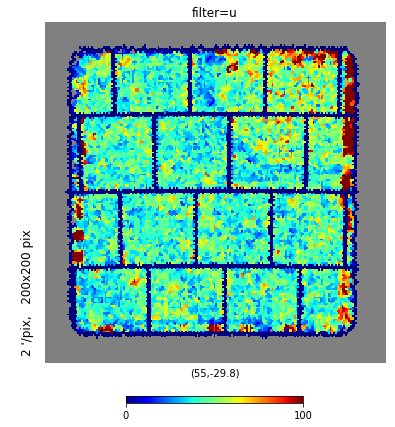

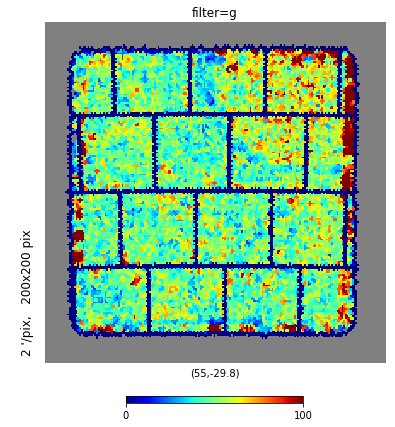

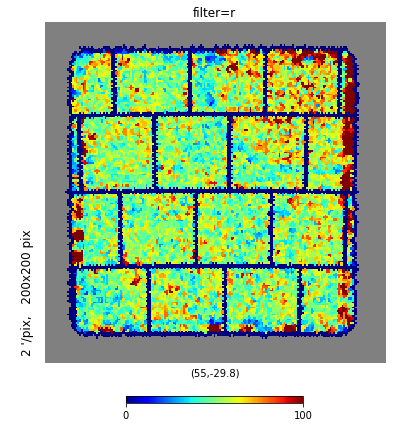

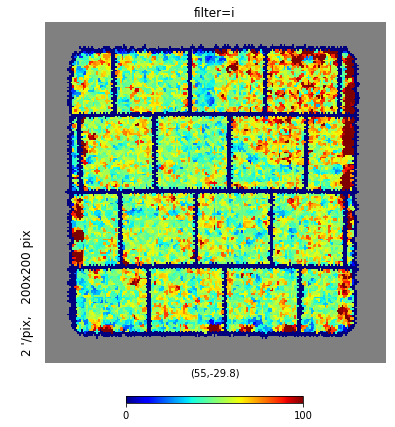

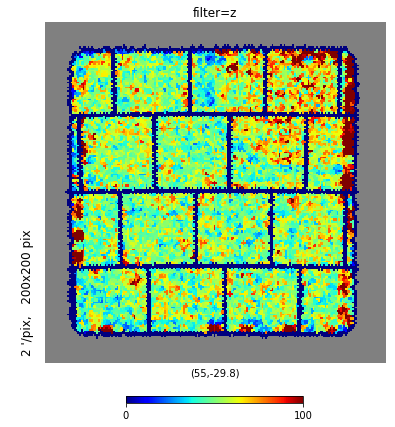

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')  #color-blind people should comment this line

for f in filters:
    flag="psFlux_flag_"+f
    dff=df.select(flag,"ipix").filter((df[flag]==True) & (df['psFlux_{}'.format(f)]>0)).na.drop()
    dff_map=dff.groupBy("ipix").count()
    map_p=dff_map.toPandas()
    print(f,map_p['count'].mean(),map_p['count'].std())
    map_c = np.zeros(hp.nside2npix(nside))
    map_c[map_p['ipix'].values]=map_p['count'].values
    map_c[map_c==0]=hp.UNSEEN
    map_c[pixborder]=-1
    hp.gnomview(map_c,rot=[55,-29.8],reso=2,title="filter="+f,min=0,max=100);